# Fine-tuning

## Autenticação

In [1]:
from os import getenv
from dotenv import load_dotenv
from huggingface_hub import login

load_dotenv(dotenv_path='../.env')

hf_token = getenv('HF_TOKEN')

assert hf_token is not None, 'Hugging Face token not found in .env file'

login(token=hf_token)

/home/erfer/Documents/UFSC/INE5443_RP/Code/Computer-Vision/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Carregamento do dataset

Generating test split: 100%|██████████| 1285/1285 [00:02<00:00, 487.17 examples/s]


Messages:
  Role: system
    Type: text
    Text: You are a model trained to identify skin lesions.
  Role: user
    Type: text
    Text: Identify the skin disease in the image.
    Type: image


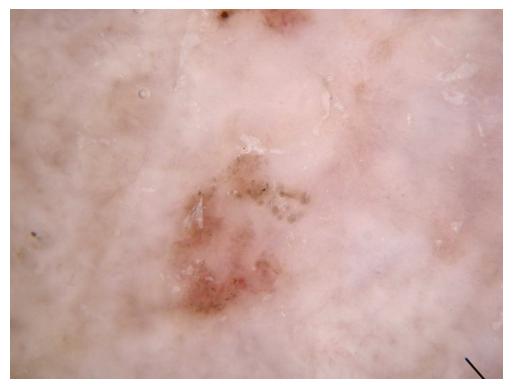

  Role: assistant
    Type: text
    Text: The skin disease in the image is actinic keratoses.
Messages:
  Role: system
    Type: text
    Text: You are a model trained to identify skin lesions.
  Role: user
    Type: text
    Text: Identify the skin disease in the image.
    Type: image


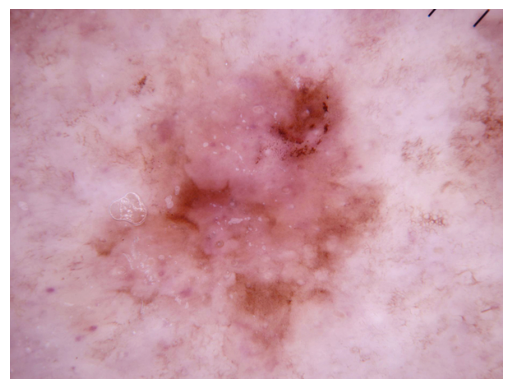

  Role: assistant
    Type: text
    Text: The skin disease in the image is actinic keratoses.
Messages:
  Role: system
    Type: text
    Text: You are a model trained to identify skin lesions.
  Role: user
    Type: text
    Text: Identify the skin disease in the image.
    Type: image


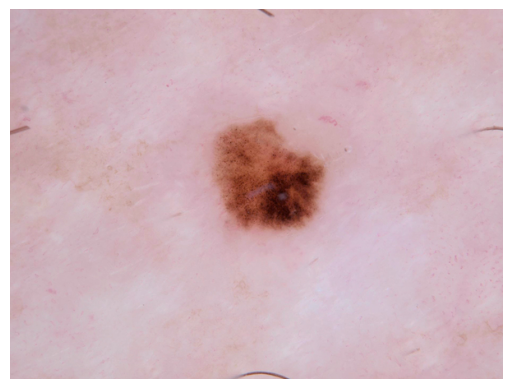

  Role: assistant
    Type: text
    Text: The skin disease in the image is actinic keratoses.


In [17]:
from datasets import load_dataset, DownloadMode
from matplotlib import pyplot as plt
import numpy as np

system_message = 'You are a model trained to identify skin lesions.'
prompt = 'Identify the skin disease in the image.'
answer = 'The skin disease in the image is {disease}.'


def format_data(sample):
    return {'messages': [
        {
            'role': 'system',
            'content': [{'type': 'text', 'text': system_message}],
        },
        {
            'role': 'user',
            'content': [
                {
                    'type': 'text',
                    'text': prompt,
                }, {
                    'type': 'image',
                    'image': sample['image'],
                }
            ],
        },
        {
            'role': 'assistant',
            'content': [{'type': 'text', 'text': answer.format(disease=sample['dx'].replace('_', ' '))}],
        },
    ],
    }


dataset = load_dataset('marmal88/skin_cancer', split='train',
                       download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS, cache_dir='../.cache')
dataset = [format_data(sample) for sample in dataset.take(3)]

for data in dataset:
    print('Messages:')
    for message in data['messages']:
        print(f'  Role: {message['role']}')
        for content in message['content']:
            print(f'    Type: {content['type']}')
            if content['type'] == 'text':
                print(f'    Text: {content['text']}')
            elif content['type'] == 'image':
                # Display the image using matplotlib
                image = content['image']
                plt.imshow(np.array(image))
                plt.axis('off')
                plt.show()

## Inicialização do LLaMa 3.2

In [10]:
import torch
from transformers import AutoProcessor
from unsloth import FastVisionModel

model_id = 'meta-llama/Llama-3.2-11B-Vision-Instruct'

model, tokenizer = FastVisionModel.from_pretrained(
    model_name=model_id,
    max_seq_length=2048,
    dtype=torch.bfloat16,
    load_in_4bit=True,
)

processor = AutoProcessor.from_pretrained(model_id)

<string>:204: SyntaxWarning: invalid escape sequence '\ '
<string>:205: SyntaxWarning: invalid escape sequence '\_'
<string>:206: SyntaxWarning: invalid escape sequence '\ '
<string>:204: SyntaxWarning: invalid escape sequence '\ '
<string>:205: SyntaxWarning: invalid escape sequence '\_'
<string>:206: SyntaxWarning: invalid escape sequence '\ '


==((====))==  Unsloth 2024.11.9: Fast Mllama vision patching. Transformers = 4.46.3.
   \\   /|    GPU: NVIDIA GeForce RTX 3060. Max memory: 11.658 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.6. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


/home/erfer/Documents/UFSC/INE5443_RP/Code/Computer-Vision/.venv/lib/python3.12/site-packages/unsloth/models/vision.py:99: SyntaxWarning: invalid escape sequence '\ '
  f"   \\\   /|    GPU: {gpu_stats.name}. Max memory: {max_memory} GB. Platform = {platform_system}.\n"\
/home/erfer/Documents/UFSC/INE5443_RP/Code/Computer-Vision/.venv/lib/python3.12/site-packages/unsloth/models/vision.py:100: SyntaxWarning: invalid escape sequence '\_'
  f"O^O/ \_/ \\    Pytorch: {torch.__version__}. CUDA = {gpu_stats.major}.{gpu_stats.minor}. CUDA Toolkit = {torch.version.cuda}.\n"\
/home/erfer/Documents/UFSC/INE5443_RP/Code/Computer-Vision/.venv/lib/python3.12/site-packages/unsloth/models/vision.py:101: SyntaxWarning: invalid escape sequence '\ '
  f"\        /    Bfloat16 = {str(SUPPORTS_BFLOAT16).upper()}. FA [Xformers = {xformers_version}. FA2 = {HAS_FLASH_ATTENTION}]\n"\


KeyboardInterrupt: 

## Fine-tuning com LoRA

In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias='none',
    target_modules=['q_proj', 'v_proj'],
    task_type='CAUSAL_LM'
)

## Configuração de treinamento

In [ ]:
from trl import SFTConfig

args = SFTConfig(
    output_dir='fine-tuned-visionllama-unsloth',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    optim='adamw_torch_fused',
    logging_steps=5,
    save_strategy='epoch',
    learning_rate=2e-4,
    bf16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type='constant',
    push_to_hub=True,
    report_to='tensorboard',
    dataset_kwargs={'skip_prepare_dataset': True},
)

## Treina o modelo

In [ ]:
from qwen_vl_utils import process_vision_info
from trl import SFTTrainer


def collate_fn(examples):
    texts = [processor.apply_chat_template(example['messages'], tokenize=False) for example in examples]
    image_inputs = [process_vision_info(example['messages'])[0]]
    for example in examples:
        batch = processor(text=texts, images=image_inputs, return_tensors='pt', padding=True)
        labels = batch['input_ids'].clone()
        labels[labels == processor.tokenizer.pad_token_id] = -100

        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]
        for image_token_id in image_tokens:
            labels[labels == image_token_id] = -100
        batch['labels'] = labels

    return batch


trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    data_collator=collate_fn,
    tokenizer=tokenizer,  # Use the tokenizer from Unsloth
    peft_config=peft_config
)

# Apply Unsloth optimizations
trainer = FastVisionModel.get_peft_model(
    trainer,
    r=8,
    target_modules=['q_proj', 'v_proj'],
    lora_alpha=16,
    lora_dropout=0.05,
    bias='none',
    use_gradient_checkpointing=True,
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

trainer.train()

## Salva o modelo

In [ ]:
peft_model = trainer.model

output_dir = '../weights'
peft_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)